In [4]:
import os
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [5]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

loaders = {
    'train': DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0),
    'test': DataLoader(test_data, batch_size=64, shuffle=True, num_workers=0)
}


In [6]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [7]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

Using device: cpu


In [8]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loaders['train'].dataset),
                100. * batch_idx / len(loaders['train']), loss.item()))

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(loaders['test'].dataset),
        100. * correct / len(loaders['test'].dataset)))

In [9]:
for epoch in range(1, 11):
    train(epoch)
    test()
torch.save(model.state_dict(), 'mnist_cnn.pt')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.285222
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.277468
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.219024
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.079007
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.798147
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.511999
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.272889
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.195530
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.004786
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.914744
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.966218
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.864003
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.023443
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.631002
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.540008
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.660857
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.693353
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.817334
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.726422
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.496966
Train Epoch: 1 [12800/60000 (

Prediction: 1


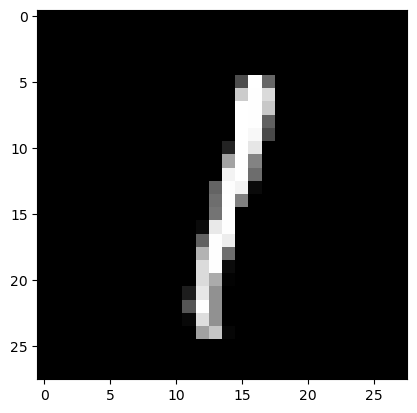

In [14]:
import random
model.load_state_dict(torch.load('mnist_cnn.pt'))
model.eval()
data, target = test_data[random.randint(0, len(test_data) - 1)]
data = data.unsqueeze(0).to(device)
output = model(data)
pred = output.argmax(dim=1, keepdim=True).item()
print('Prediction:', pred)
image = data.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(image, cmap='gray')
plt.show()